In [1]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

In [2]:
data_path = 'data_ddm.csv'
original_data = pd.read_csv(data_path)

In [3]:
mean_rt = original_data.groupby(['id', 'cond'])['rt'].mean().reset_index()
original_data['correct'] = (original_data['choice'] == 'correct').astype(int)
mean_accuracy = original_data.groupby(['id', 'cond'])['correct'].mean().reset_index()
subjects_to_exclude = mean_accuracy[mean_accuracy['correct'] < 0.5]['id'].unique()
revised_filtered_mean_accuracy = mean_accuracy[~mean_accuracy['id'].isin(subjects_to_exclude)].copy()  
revised_filtered_mean_accuracy.loc[:, 'age_group'] = revised_filtered_mean_accuracy['id'].apply(lambda x: 'old' if str(x).startswith('o') else 'young')
combined_data = pd.merge(mean_rt, revised_filtered_mean_accuracy, on=['id', 'cond'], how='inner')

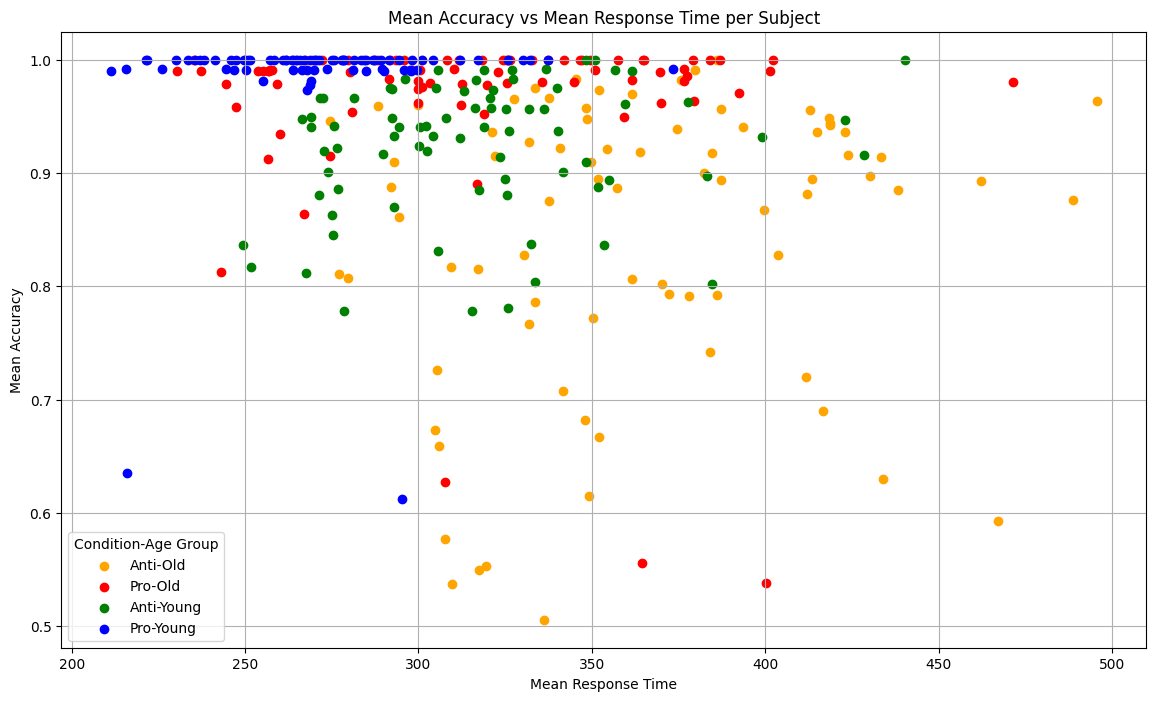

In [4]:
plt.figure(figsize=(14, 8))

color_dict = {
    ('young', 'pro'): 'blue',
    ('young', 'anti'): 'green',
    ('old', 'pro'): 'red',
    ('old', 'anti'): 'orange'
}

combined_data['color'] = combined_data.apply(lambda x: color_dict[(x['age_group'], x['cond'])], axis=1)

for (age_group, cond), group_data in combined_data.groupby(['age_group', 'cond']):
    plt.scatter(group_data['rt'], group_data['correct'], color=color_dict[(age_group, cond)], label=f"{cond.capitalize()}-{age_group.capitalize()}")

plt.title('Mean Accuracy vs Mean Response Time per Subject')
plt.xlabel('Mean Response Time')
plt.ylabel('Mean Accuracy')
plt.legend(title='Condition-Age Group')
plt.grid(True)
plt.show()


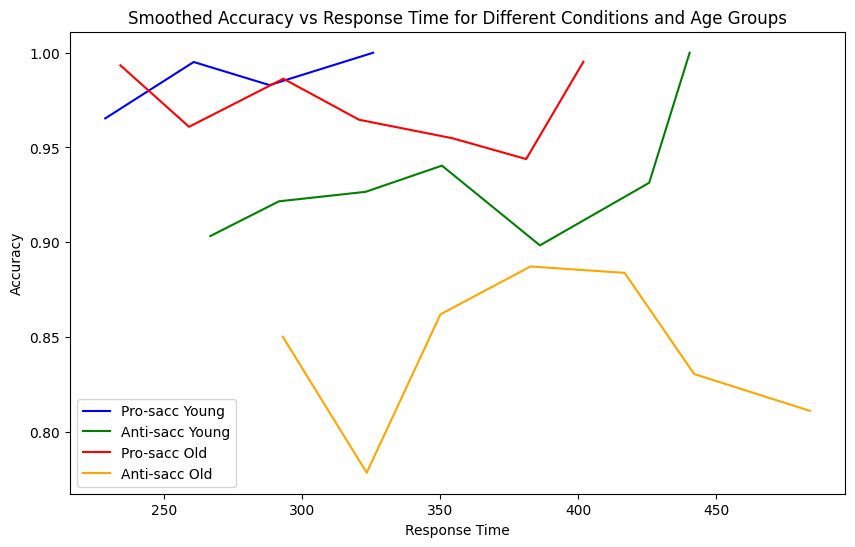

In [5]:

# Function to calculate accuracy and average response time in bins for smoother curves
def calculate_accuracy_rt_bins(dataset, condition, bins):
    condition_data = dataset[dataset['cond'] == condition].copy()
    condition_data.loc[:, 'rt_bin'] = pd.cut(condition_data['rt'], bins=bins, labels=range(len(bins)-1))
    accuracy_rt_bins = condition_data.groupby('rt_bin').agg({'correct': 'mean', 'rt': 'mean'})
    return accuracy_rt_bins['correct'], accuracy_rt_bins['rt']

young_data = combined_data[~combined_data['id'].astype(str).str.startswith('o')]
old_data = combined_data[combined_data['id'].astype(str).str.startswith('o')]

rt_bins = np.linspace(combined_data['rt'].min(), combined_data['rt'].max(), 10)

young_pro_acc_bins, young_pro_rt_bins = calculate_accuracy_rt_bins(young_data, 'pro', rt_bins)
young_anti_acc_bins, young_anti_rt_bins = calculate_accuracy_rt_bins(young_data, 'anti', rt_bins)
old_pro_acc_bins, old_pro_rt_bins = calculate_accuracy_rt_bins(old_data, 'pro', rt_bins)
old_anti_acc_bins, old_anti_rt_bins = calculate_accuracy_rt_bins(old_data, 'anti', rt_bins)

plt.figure(figsize=(10, 6))

plt.plot(young_pro_rt_bins, young_pro_acc_bins, label='Pro-sacc Young', color='blue')
plt.plot(young_anti_rt_bins, young_anti_acc_bins, label='Anti-sacc Young', color='green')
plt.plot(old_pro_rt_bins, old_pro_acc_bins, label='Pro-sacc Old', color='red')
plt.plot(old_anti_rt_bins, old_anti_acc_bins, label='Anti-sacc Old', color='orange')

plt.xlabel('Response Time')
plt.ylabel('Accuracy')
plt.title('Smoothed Accuracy vs Response Time for Different Conditions and Age Groups')
plt.legend()
plt.show()


In [6]:

# Exponential fit function
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Function to prepare data for fitting, excluding NaN values
def prepare_data_for_fitting(acc_bins, rt_bins):
    valid_data = ~(acc_bins.isna() | rt_bins.isna())
    return rt_bins[valid_data], acc_bins[valid_data]

# Function to fit the exponential function to the data
def fit_exponential_function(x, y):
    init_param = (max(y), 0.01, min(y))  # Initial parameters for curve fitting
    params, params_covariance = curve_fit(exp_func, x, y, p0=init_param, maxfev=5000)
    fitted_values = exp_func(x, *params)
    return x, fitted_values, params

try:
    young_pro_rt_fit, young_pro_acc_fit, young_pro_params = fit_exponential_function(*prepare_data_for_fitting(young_pro_acc_bins, young_pro_rt_bins))
    young_anti_rt_fit, young_anti_acc_fit, young_anti_params = fit_exponential_function(*prepare_data_for_fitting(young_anti_acc_bins, young_anti_rt_bins))
    old_pro_rt_fit, old_pro_acc_fit, old_pro_params = fit_exponential_function(*prepare_data_for_fitting(old_pro_acc_bins, old_pro_rt_bins))
    old_anti_rt_fit, old_anti_acc_fit, old_anti_params = fit_exponential_function(*prepare_data_for_fitting(old_anti_acc_bins, old_anti_rt_bins))

    plt.figure(figsize=(10, 6))

    plt.plot(young_pro_rt_fit, young_pro_acc_fit, label='Pro-sacc Young (Fitted)', color='blue')
    plt.plot(young_anti_rt_fit, young_anti_acc_fit, label='Anti-sacc Young (Fitted)', color='green')
    plt.plot(old_pro_rt_fit, old_pro_acc_fit, label='Pro-sacc Old (Fitted)', color='red')
    plt.plot(old_anti_rt_fit, old_anti_acc_fit, label='Anti-sacc Old (Fitted)', color='orange')

    plt.xlabel('Response Time')
    plt.ylabel('Accuracy')
    plt.title('Fitted Exponential Accuracy vs Response Time for Different Conditions and Age Groups')
    plt.legend()
    plt.show()

except RuntimeError as e:
    print(f"Could not fit the exponential function: {e}")

Could not fit the exponential function: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.


fixed

/home/ubuntu/.local/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


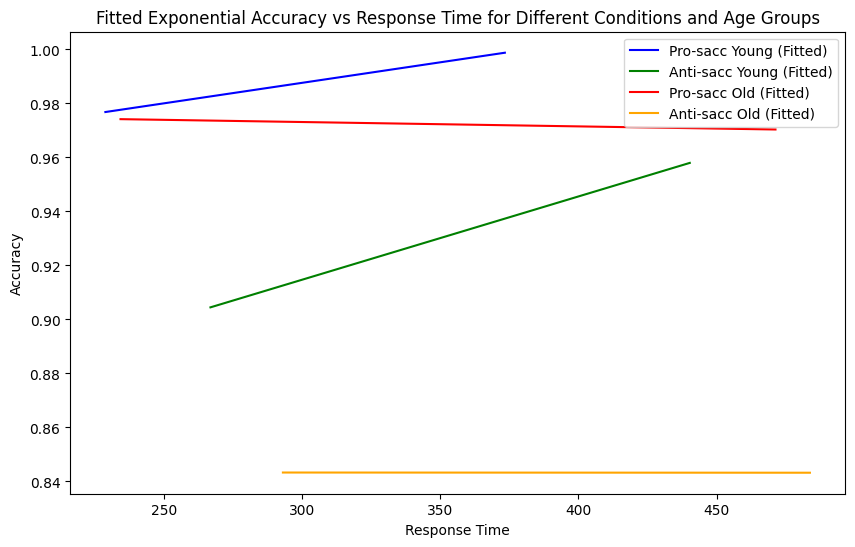

In [7]:
def fit_exponential_function_adjusted(x, y):
    init_param = (1, 1e-6, y.mean())  # Adjusted 
    try:
        params, params_covariance = curve_fit(exp_func, x, y, p0=init_param, maxfev=10000)
        fitted_values = exp_func(x, *params)
        return x, fitted_values, params
    except RuntimeError as e:
        print(f"Could not fit the exponential function: {e}")
        return x, np.full_like(x, np.nan), (np.nan, np.nan, np.nan)  
    
young_pro_rt_fit, young_pro_acc_fit, young_pro_params = fit_exponential_function_adjusted(*prepare_data_for_fitting(young_pro_acc_bins, young_pro_rt_bins))
young_anti_rt_fit, young_anti_acc_fit, young_anti_params = fit_exponential_function_adjusted(*prepare_data_for_fitting(young_anti_acc_bins, young_anti_rt_bins))
old_pro_rt_fit, old_pro_acc_fit, old_pro_params = fit_exponential_function_adjusted(*prepare_data_for_fitting(old_pro_acc_bins, old_pro_rt_bins))
old_anti_rt_fit, old_anti_acc_fit, old_anti_params = fit_exponential_function_adjusted(*prepare_data_for_fitting(old_anti_acc_bins, old_anti_rt_bins))

if not np.isnan(young_pro_params).any():
    plt.figure(figsize=(10, 6))

    if not np.isnan(young_pro_params).any():
        plt.plot(young_pro_rt_fit, young_pro_acc_fit, label='Pro-sacc Young (Fitted)', color='blue')
    if not np.isnan(young_anti_params).any():
        plt.plot(young_anti_rt_fit, young_anti_acc_fit, label='Anti-sacc Young (Fitted)', color='green')
    if not np.isnan(old_pro_params).any():
        plt.plot(old_pro_rt_fit, old_pro_acc_fit, label='Pro-sacc Old (Fitted)', color='red')
    if not np.isnan(old_anti_params).any():
        plt.plot(old_anti_rt_fit, old_anti_acc_fit, label='Anti-sacc Old (Fitted)', color='orange')

    plt.xlabel('Response Time')
    plt.ylabel('Accuracy')
    plt.title('Fitted Exponential Accuracy vs Response Time for Different Conditions and Age Groups')
    plt.legend()
    plt.show()
else:
    print("Exponential fitting was not successful for any of the groups.")
